0) Librairies and "Plot" Function

In [191]:
import pylab as pl
import openturns as ot
import openturns.viewer as otv
from openturns.usecases import flood_model

from matplotlib import pylab as plt
import numpy as np
import scipy.stats as scs 

In [192]:
def plotDistributionGridPDF(distribution):
    """
    Plot the marginal and bi-dimensional iso-PDF on a grid.

    Parameters
    ----------
    distribution : ot.Distribution
        The distribution.

    Returns
    -------
    grid : ot.GridLayout(dimension, dimension)
        The grid of plots.

    """
    dimension = distribution.getDimension()
    grid = ot.GridLayout(dimension, dimension)
    for i in range(dimension):
        for j in range(dimension):
            if i == j:
                distributionI = distribution.getMarginal([i])
                graph = distributionI.drawPDF()
            else:
                distributionJI = distribution.getMarginal([j, i])
                graph = distributionJI.drawPDF()
            graph.setLegends([""])
            graph.setTitle("")
            if i < dimension - 1:
                graph.setXTitle("")
            if j > 0:
                graph.setYTitle("")
            grid.setGraph(i, j, graph)
    grid.setTitle("Iso-PDF values")
    return grid

1. Models and Input

A. Fluage (Eurocode) - Input

In [193]:
# INPUT

# Observation

dim_eurocode = 4
input_eurocode = ["uRh", "bfcm", "bt0", "t"]

dim_calibrated = 3
index_calibrated = [0, 1, 2]
input_calibrated = ["uRh", "bfcm", "bt0"]

obsSize = 100
true_mean_uRH, true_mean_bfcm, true_mean_bt0 = 0.451869, 2.7619, 0.48845
thetaTrue = [true_mean_uRH, true_mean_bfcm, true_mean_bt0]
stdobs = 0.15

errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0, 0] = stdobs ** 2

# Input 

tmin = 0.0
tmax = 200

step = (tmax - tmin) / (obsSize - 1)
rg = ot.RegularGrid(tmin, step, obsSize)
t_obs = rg.getVertices()

# Prior and calibration input

prior_mean_uRH, prior_mean_bfcm, prior_mean_bt0 = 1, 5, 1
std_uRH, std_bfcm, std_bt0 = 0.25, 1.5, 0.25

thetaPriorMean = [prior_mean_uRH, prior_mean_bfcm, prior_mean_bt0] # Mean Prior
sigma0 = [std_uRH, std_bfcm, std_bt0]  # standard Deviations

sigma = ot.CovarianceMatrix(3)
sigma[0, 0] = std_uRH ** 2
sigma[1, 1] = std_bfcm ** 2
sigma[2, 2] = std_bt0 ** 2

B. Blackbox Model + LinkedFunction

In [194]:
# BLAXBOX MODEL

fluage_eurocode = ot.SymbolicFunction(
    input_eurocode, ["max(uRh*bfcm*bt0*((t-28)/(477.90+t-28)))", "1.0"]
)

linkFunction = ot.ParametricFunction(fluage_eurocode, [3], [100])

noise = ot.Normal(0, stdobs)
noiseSample = noise.getSample(obsSize)

y_obs = ot.Sample(obsSize, 1)
for i in range(obsSize):
    linkFunction.setParameter(t_obs[i])
    y_obs[i, 0] = linkFunction(thetaTrue)[0] + noiseSample[i, 0]

print(linkFunction)

ParametricEvaluation([uRh,bfcm,bt0,t]->[max(uRh*bfcm*bt0*((t-28)/(477.90+t-28))),1.0], parameters positions=[3], parameters=[t : 200], input positions=[0,1,2])


C. Blackbox Model + Prior Model

In [195]:
# MODEL

def fluage_eurocode_formula(x):
    y = x[0] * x[1] * x[2] * ((x[3] - 28)/(477.90 + x[3] - 28))
    return [y]

f_fluage = ot.PythonFunction(dim_eurocode, 1, fluage_eurocode_formula)
f_fluage = ot.MemoizeFunction(f_fluage) 
f_fluage.setInputDescription(input_eurocode)
f_fluage.setOutputDescription(["fluage"])

prior_model_fluage = ot.ParametricFunction(f_fluage, [0, 1, 2], thetaPriorMean)
true_fluage = ot.ParametricFunction(f_fluage, [0, 1, 2], thetaTrue)

print(prior_model_fluage)

ParametricEvaluation(MemoizeEvaluation(class=PythonEvaluation name=OpenTURNSPythonFunction), parameters positions=[0,1,2], parameters=[uRh : 1, bfcm : 5, bt0 : 1], input positions=[3])


D. Plot

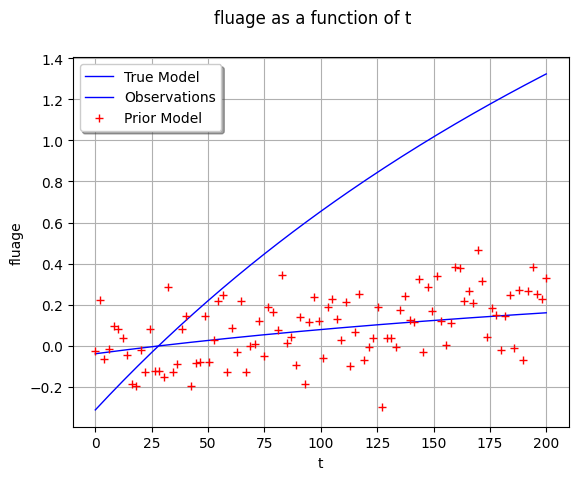

In [196]:
graphModel1 = true_fluage.draw(tmin, tmax)
prior_fluage = prior_model_fluage.getMarginal(0).draw(tmin, tmax)

graphModel1.add(prior_fluage)

observations = ot.Cloud(t_obs, y_obs)
observations.setColor("red")
graphModel1.add(observations)

graphModel1.setLegends(["True Model", "Observations", "Prior Model"])
graphModel1.setLegendPosition("topleft")
view = otv.View(graphModel1)

2. Calibration Methods (Part 1)

In [197]:
type_algo = 'NLLS'

# LinearLeastSquaresCalibration

if type_algo == 'LLS':
    algo = ot.LinearLeastSquaresCalibration(prior_model_fluage, t_obs, y_obs, thetaPriorMean)

# NonLinearLeastSquaresCalibration

if type_algo == 'NLLS':
    algo = ot.NonLinearLeastSquaresCalibration(prior_model_fluage, t_obs, y_obs, thetaPriorMean)

# Gaussian linear calibration
"""
The GaussianLinearCalibration class performs the Gaussian linear calibration by linearizing the model in the neighbourhood of the prior. 
This is also known as the Kalman filter.
"""
if type_algo == 'LGP':
    algo = ot.GaussianLinearCalibration(
        prior_model_fluage, t_obs, y_obs, thetaPriorMean, sigma, errorCovariance
    )

# Gaussian nonlinear calibration
"""
This algorithm is also known as 3DVar
"""
if type_algo == 'NLGP':
    algo = ot.GaussianNonLinearCalibration(
        prior_model_fluage, t_obs, y_obs, thetaPriorMean, sigma, errorCovariance
    )

In [198]:
algo.run()
calibrationResult = algo.getResult()
thetaMAP = calibrationResult.getParameterMAP()

print('theta prior : ' + str(thetaPriorMean))
print('theta MAP : ' + str(thetaMAP))
print('theta True : ' + str(thetaTrue))

theta prior : [1, 5, 1]
theta MAP : [0.533349,2.66675,0.533349]
theta True : [0.451869, 2.7619, 0.48845]


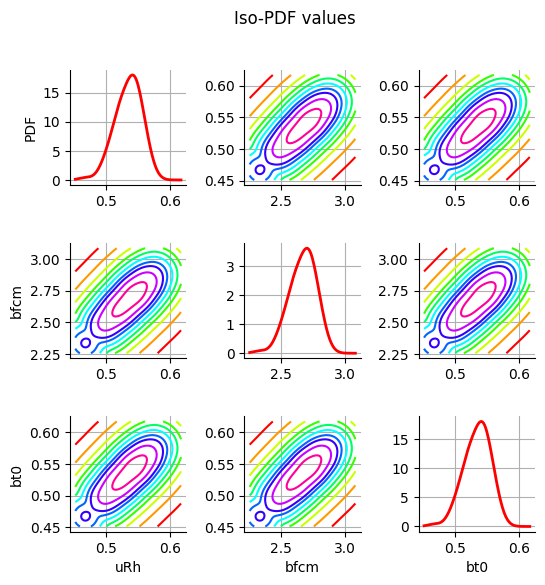

In [199]:
# Plot the PDF values of the distribution of the optimum parameters

thetaPosterior = calibrationResult.getParameterPosterior()

grid = plotDistributionGridPDF(thetaPosterior)
view = otv.View(
    grid,
    figure_kw={"figsize": (6.0, 6.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
plot_space = 0.5
plt.subplots_adjust(wspace=plot_space, hspace=plot_space)

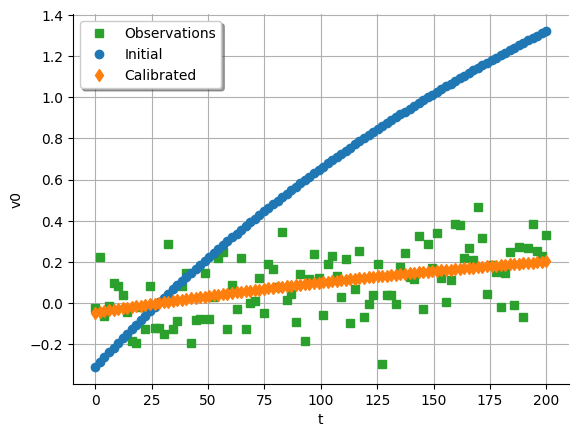

In [200]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
view = otv.View(graph)

3. Calibration Methods (Part 2)

In [201]:
conditional = ot.Normal()
thetaPriorCovarianceMatrix = ot.CovarianceMatrix(dim_calibrated)

for i in range(dim_calibrated):
    thetaPriorCovarianceMatrix[i, i] = sigma0[i] ** 2

prior = ot.Normal(thetaPriorMean, thetaPriorCovarianceMatrix)
prior.setDescription(input_calibrated)
proposal = ot.Uniform(-1.0, 1.0)

In [202]:
# Gibbs algo
sampleSize = 10000

# Metropolis-Hastings Sampler

initialState = thetaPriorMean

# We create a RandomWalkMetropolisHastings sampler for each component. Each sampler must be aware of the joint prior distribution

mh_coll = [
    ot.RandomWalkMetropolisHastings(prior, initialState, proposal, [i])
    for i in range(dim_calibrated)
]

# Each sampler must be made aware of the likelihood

for mh in mh_coll:
    mh.setLikelihood(conditional, y_obs, linkFunction, t_obs)

# the Gibbs algorithm is constructed from all Metropolis-Hastings samplers

sampler = ot.Gibbs(mh_coll)
sample = sampler.getSample(sampleSize)

uRhcali, bfcmcali, bt0cali = np.mean(sample[:,0]), np.mean(sample[:,1]), np.mean(sample[:,2])

[mh.getAcceptanceRate() for mh in sampler.getMetropolisHastingsCollection()]

[0.2673, 0.3048, 0.2748]

0.7583062122553718 2.9163964926658004 0.7821105028599575
[0.451869, 2.7619, 0.48845]


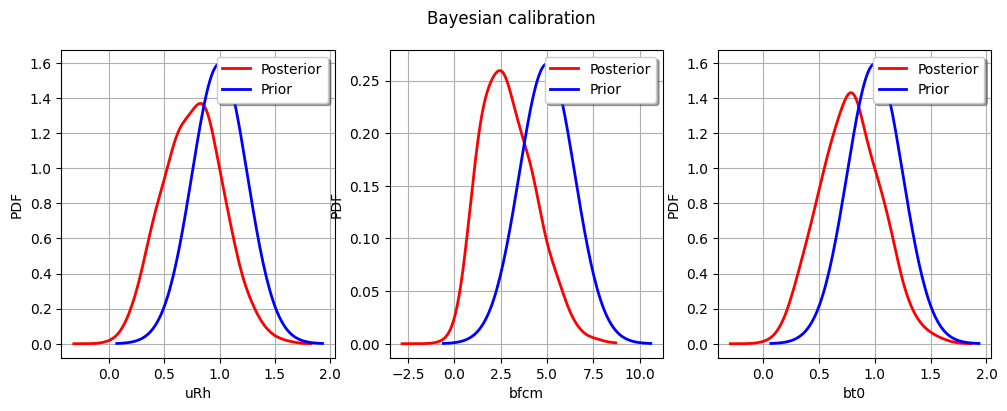

In [203]:
# Build the distribution of the posterior by kernel smoothing

print(uRhcali, bfcmcali, bt0cali)
print(thetaTrue)

kernel = ot.KernelSmoothing()
posterior = kernel.build(sample)

fig = pl.figure(figsize=(12, 4))

for parameter_index in range(dim_calibrated):
    graph = posterior.getMarginal(parameter_index).drawPDF()
    priorGraph = prior.getMarginal(parameter_index).drawPDF()
    priorGraph.setColors(["blue"])
    graph.add(priorGraph)
    graph.setLegends(["Posterior", "Prior"])
    ax = fig.add_subplot(1, dim_calibrated, parameter_index + 1)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

_ = fig.suptitle("Bayesian calibration")

plt.show()
